# Download data from kaggle to colab & unzip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### Download data from kaggle to colab
# https://www.kaggle.com/general/74235
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
# ! kaggle competitions download -c plant-seedlings-classification

In [ ]:
!unzip drive/MyDrive/plant_seedlings_classification/plant_seedlings_classification.zip -d image_all
!rm -r image_all/test/

import os
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
import matplotlib.cm as cm
import pandas as pd
import tensorflow as tf
import random
import math
from PIL import Image
from PIL import ImageFilter
import seaborn as sns

# t-SNE and plot of data points

In [ ]:
def create_mask_for_plant(image):
  image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  sensitivity = 35
  lower_hsv = np.array([60 - sensitivity, 100, 50])
  upper_hsv = np.array([60 + sensitivity, 255, 255])

  mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  return mask

def segment_plant(image):
  mask = create_mask_for_plant(image)
  output = cv2.bitwise_and(image, image, mask=mask)
  return output

def visualize_scatter_with_images(X_2d_data, images, figsize=(45,45), image_zoom = 1):
  fig, ax = plt.subplot(figsize=figsize)
  artists = []
  for xy,i in zip(X_2d_data, images):
    x0,y0 = xy
    img = OffsetImage(i, zoom=image_zoom)
    ab = AnnotationBbox(img, (x0,y0), xycoords='data', frameon=False)
    artists.append(ax.add_artists(ab))
  ax.update_datalim(X_2d_data)
  ax.autoscale()
  plt.show()

def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
  plt.figure(figsize=figsize)
  plt.grid()

  nb_classes = len(np.unique(label_ids))

  for label_id in np.unique(label_ids):
    plt.scatter(data_2d[np.where(label_ids == label_id),0],
                data_2d[np.where(label_ids == label_id),1],
                marker = 'o',
                color = plt.cm.Set1(label_id / float(nb_classes)),
                linewidth='1',
                alpha=0.8,
                label = id_to_label_dict[label_id])
  plt.legend(loc='best')

In [ ]:
### Collet all images and labels
images = []
labels = []
trainpath = 'image_all/train/'
for class_folder_name in os.listdir(trainpath):
  class_folder_path = os.path.join(trainpath, class_folder_name)
  for image_path in glob(os.path.join(class_folder_path, "*.png")):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (150,150))
    image = segment_plant(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (45,45))

    image = image.flatten()

    images.append(image)
    labels.append(class_folder_name)

images = np.array(images)
labels = np.array(labels)

### Get label index for all images
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v:k for k,v in label_to_id_dict.items()}
label_ids = np.array([label_to_id_dict[x] for x in labels])
### Standardize image data
images_scaled = StandardScaler().fit_transform(images)

### Sample view of resized, grayscale image

In [ ]:
### Sample view of image  
# plt.imshow(np.reshape(images[1], (45,45)), cmap="gray")

### Apply PCA

In [ ]:
### apply PCA
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)

### Apply t-SNE after PCA

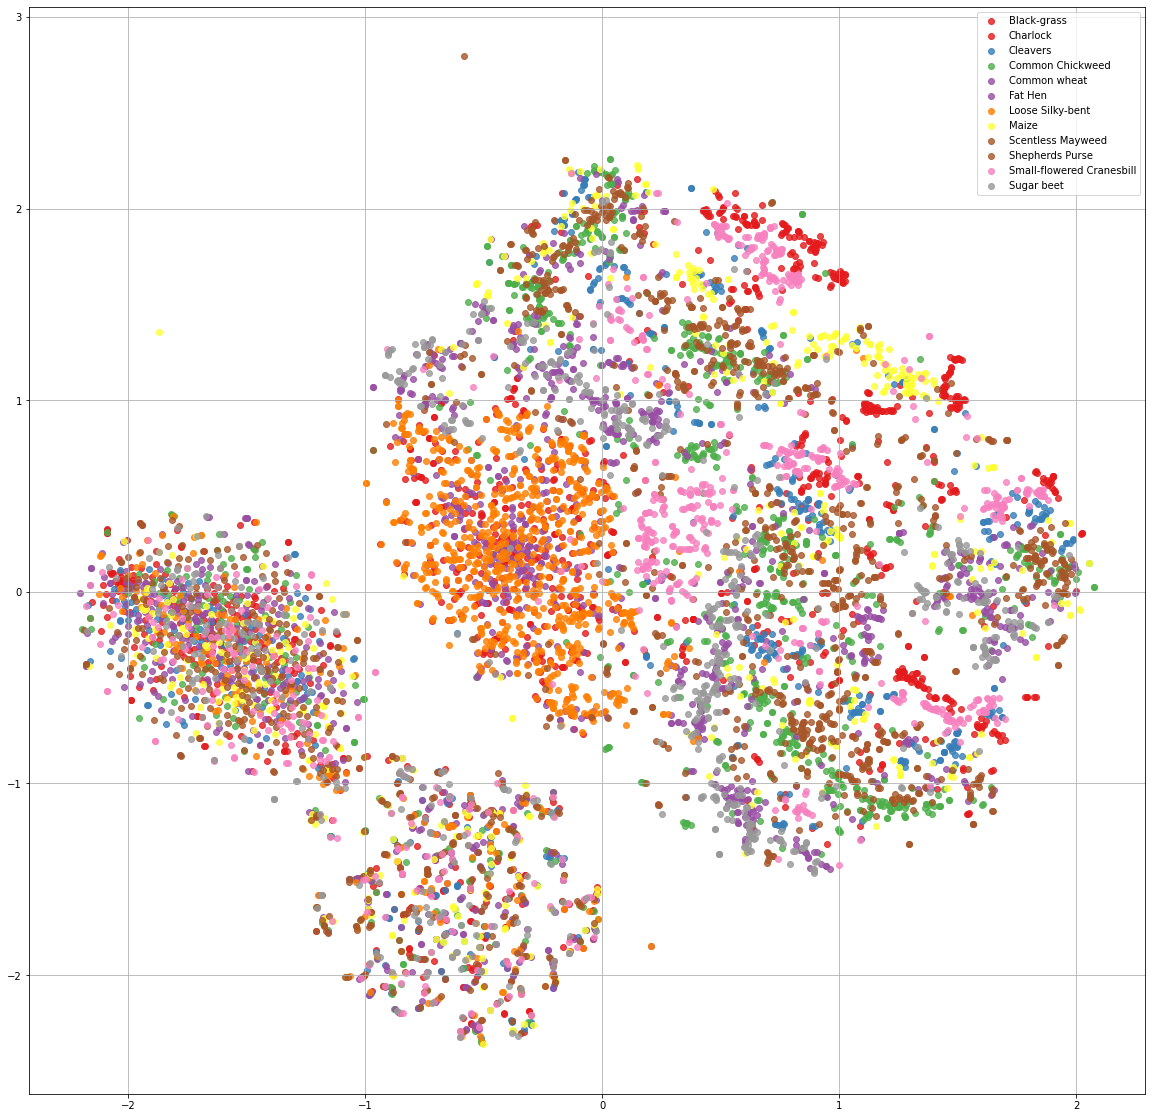

In [ ]:
### t-SNE (perplexity: 5~50)
### then visualize
tsne = TSNE(n_components=2, perplexity=30.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
visualize_scatter(tsne_result_scaled, label_ids)

# Fit model (Without oversampling)



### Create a test set (20% of total sample)

In [ ]:
### Create a test set (stratified sample 20% of 4750 total images)
os.mkdir('image_all/test/')
label_names = os.listdir('image_all/train/')
for label in label_names:
  os.mkdir('image_all/test/' + label)
random.seed(9345)
for label in label_names:
  imnames = os.listdir(os.path.join('image_all/train/', label))
  nb_sample = math.floor(len(imnames)*0.2)
  test_img_name = random.sample(imnames, nb_sample)
  print(len(test_img_name))
  for name in test_img_name:
    readpath = 'image_all/train/'+label+'/'+name
    img = Image.open(readpath)
    savepath = 'image_all/test/'+label+'/'+name
    img.save(savepath)
    os.remove(readpath)

### Image generator

In [ ]:
nb_epoch     = 100
batch_size   = 32
width        = 299
height       = 299


def define_generators():
  ### Train and validate generator
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shisft_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0.25, # change to use validation instead of training on entire training set
  )

  train_generator = train_datagen.flow_from_directory(
      directory='image_all/train',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='training',
  )

  validation_generator = train_datagen.flow_from_directory(
      directory='image_all/train',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='validation',
  )

  ### Test generator
  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shift_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0,
  )

  test_generator = test_datagen.flow_from_directory(
      directory='image_all/test',
      target_size=(width, height),
      batch_size=1,
      color_mode='rgb',
      shuffle=False,
      class_mode='categorical')

  return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = define_generators()

Found 2855 images belonging to 12 classes.
Found 948 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


### CNN (baseline model)

In [ ]:
model_cnn = tf.keras.models.Sequential()
# Input layer
# Can be omitted, you can specify the input_shape in other layers
model_cnn.add(tf.keras.layers.InputLayer(input_shape=(width,height,3,)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model_cnn.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model_cnn.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model_cnn.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model_cnn.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model_cnn.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model_cnn.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model_cnn.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model_cnn.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model_cnn.add(tf.keras.layers.Flatten())

model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model_cnn.add(tf.keras.layers.Dropout(0.2))
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model_cnn.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model_cnn.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn.summary()


# You can save the best model to the checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/plant_seedlings_classification/modelresult_CNN_no_oversample.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)


### Fit model on training and validation
history = model_cnn.fit(train_generator,
          epochs=nb_epoch, # Increase number of epochs if you have sufficient hardware
          steps_per_epoch= train_generator.samples//batch_size,  # Number of train images // batch_size
          validation_data=validation_generator,
          validation_steps = validation_generator.samples//batch_size, # Number of val images // batch_size
          callbacks = [checkpoint],
          verbose = 1)

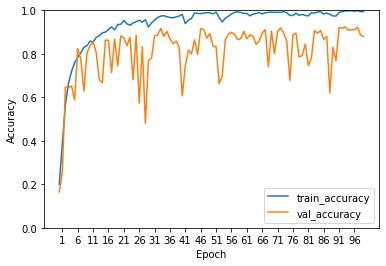

In [11]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/CNN_train_valid_no_oversample.png')

In [ ]:
### Prediction on test set
predictions = model_cnn.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )

## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_CNN_no_oversample_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
conf_mat
### save training History as 'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_CNN_train_valid_no_oversample.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_CNN_no_oversample_CFmat.csv')
a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

### InceptionResNetV2



In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='drive/MyDrive/plant_seedlings_classification/ResNet_no_oversample.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return save_callback
def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
model_inceptionResNetv2 = define_model(width, height)
model_inceptionResNetv2.summary()
save_callback = define_callbacks()
history = model_inceptionResNetv2.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[save_callback] #UNCOMMENT THIS LINE TO SAVE BEST VAL_ACC MODEL
)

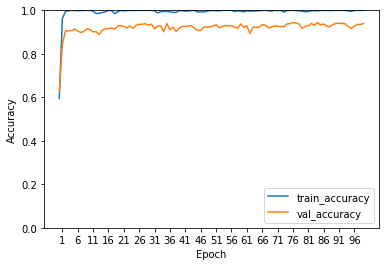

In [17]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/ResNet_train_valid_no_oversample.png')

219062272/219055592 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12583040  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 66,921,324
Trainable params: 66,860,780
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/100
89/89 [========================

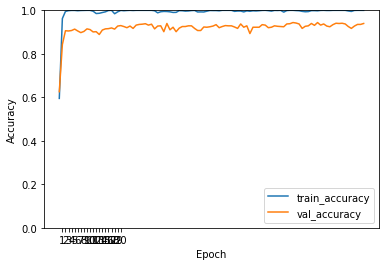

In [ ]:
### Prediction on test set
predictions = model_inceptionResNetv2.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )
## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_ResNet_no_oversample_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_ResNet_train_valid_no_oversample.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

# Fit model (With oversampling)

### Create oversamples
```
sample 60 images from labels with size < 200
sample 40 images from labels with size < 400
4 transformation types were applied to each of 50 images
```

In [ ]:
### Before Oversample
labels = os.listdir('image_all/train/')
train_sizes = [len(os.listdir('image_all/train/' + x + '/')) for x in labels]
{x:y for x,y in zip(labels,train_sizes)}
plt.bar(range(len(labels)),train_sizes)
plt.xticks(range(len(labels)),labels, rotation=90)

In [ ]:
random.seed(10)
for idx,label in enumerate(labels):
  if train_sizes[idx] < 200:
    ossize = 60
  elif train_sizes[idx] < 400:
    ossize = 40
  else:
    ossize = 1
  img_names = os.listdir('image_all/train/' + label)
  img_names_select = random.sample(img_names, ossize)
  for name_i in img_names_select:
    im=Image.open('image_all/train/' + label + '/' + name_i)
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    r.save('image_all/train/'+label+'/r_'+name_i)
    g=g.convert("RGB")
    g.save('image_all/train/'+label+'/g_'+name_i)
    b=b.convert("RGB")
    b.save('image_all/train/'+label+'/b_'+name_i)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    im_unsharp.save('image_all/train/'+label+'/unsharp_'+name_i)


In [ ]:
### After Oversample
labels = os.listdir('image_all/train/')
train_sizes = [len(os.listdir('image_all/train/' + x + '/')) for x in labels]
{x:y for x,y in zip(labels,train_sizes)}

([<matplotlib.axis.XTick at 0x7f8b20567dd0>,
 [Text(0, 0, 'Scentless Mayweed'),
  Text(0, 0, 'Common wheat'),
  Text(0, 0, 'Charlock'),
  Text(0, 0, 'Black-grass'),
  Text(0, 0, 'Maize'),
  Text(0, 0, 'Shepherds Purse'),
  Text(0, 0, 'Loose Silky-bent'),
  Text(0, 0, 'Common Chickweed'),
  Text(0, 0, 'Fat Hen'),
  Text(0, 0, 'Cleavers'),
  Text(0, 0, 'Small-flowered Cranesbill'),
  Text(0, 0, 'Sugar beet')])

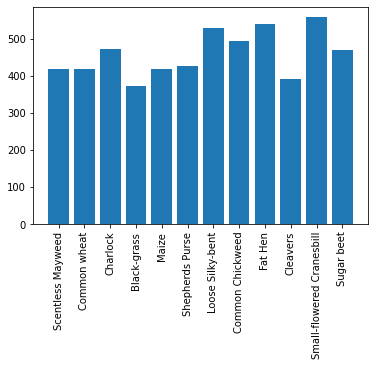

In [ ]:
plt.bar(range(len(labels)),train_sizes)
plt.xticks(range(len(labels)),labels, rotation=90)

### Image generator

In [ ]:
nb_epoch     = 100
batch_size   = 32
width        = 299
height       = 299


def define_generators():
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shift_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0.25, # change to use validation instead of training on entire training set
  )

  train_generator = train_datagen.flow_from_directory(
      directory='image_all/train',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='training',
  )

  validation_generator = train_datagen.flow_from_directory(
      directory='image_all/train',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='validation',
  )

  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shift_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0,
  )

  test_generator = test_datagen.flow_from_directory(
      directory='image_all/test',
      target_size=(width, height),
      batch_size=1,
      color_mode='rgb',
      shuffle=False,
      class_mode='categorical')

  return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = define_generators()

Found 4535 images belonging to 12 classes.
Found 1508 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


### CNN (baseline model)

In [ ]:
model = tf.keras.models.Sequential()
# Input layer
# Can be omitted, you can specify the input_shape in other layers
model.add(tf.keras.layers.InputLayer(input_shape=(width,height,3,)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/plant_seedlings_classification/plant_classifier_CNN_oversample.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

history = model.fit(train_generator,
          epochs=nb_epoch, # Increase number of epochs if you have sufficient hardware
          steps_per_epoch= train_generator.samples//batch_size,  # Number of train images // batch_size
          validation_data=validation_generator,
          validation_steps = validation_generator.samples//batch_size, # Number of val images // batch_size
          callbacks = [checkpoint],
          verbose = 1)

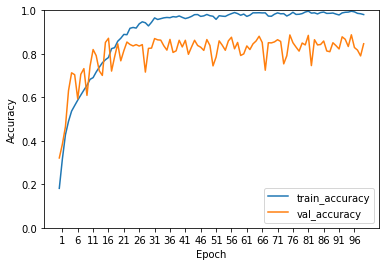

In [18]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/CNN_train_valid_with_oversample.png')

Epoch 1/100
141/141 [==============================] - 73s 503ms/step - loss: 2.6714 - accuracy: 0.1393 - val_loss: 2.0412 - val_accuracy: 0.3211

Epoch 00001: val_accuracy improved from -inf to 0.32114, saving model to drive/MyDrive/plant_seedlings_classification/plant_classifier_CNN_oversample.h5
Epoch 2/100
141/141 [==============================] - 70s 498ms/step - loss: 2.0664 - accuracy: 0.2842 - val_loss: 1.6617 - val_accuracy: 0.3843

Epoch 00002: val_accuracy improved from 0.32114 to 0.38431, saving model to drive/MyDrive/plant_seedlings_classification/plant_classifier_CNN_oversample.h5
Epoch 3/100
141/141 [==============================] - 70s 496ms/step - loss: 1.7243 - accuracy: 0.3891 - val_loss: 1.5149 - val_accuracy: 0.4654

Epoch 00003: val_accuracy improved from 0.38431 to 0.46543, saving model to drive/MyDrive/plant_seedlings_classification/plant_classifier_CNN_oversample.h5
Epoch 4/100
141/141 [==============================] - 70s 499ms/step - loss: 1.5145 - accurac

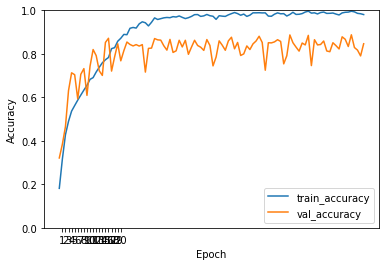

In [ ]:
### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )


## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_CNN_with_oversample_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
conf_mat


### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
import pandas as pd
save_name = 'modelresult_CNN_train_valid_with_oversample.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### InceptionResNetV2



In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='drive/MyDrive/plant_seedlings_classification/ResNet_with_oversample.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return save_callback
def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
model = define_model(width, height)
model.summary()
save_callback = define_callbacks()

history = model.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[save_callback] #UNCOMMENT THIS LINE TO SAVE BEST VAL_ACC MODEL
)


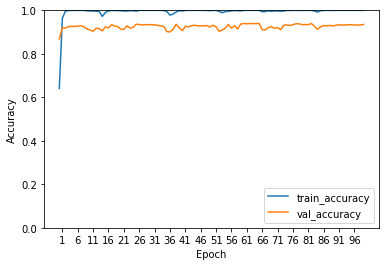

In [20]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/ResNet_train_valid_with_oversample.png')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               12583040  
_________________________________________________________________
dense_6 (Dense)              (None, 12)                1548      
Total params: 66,921,324
Trainable params: 66,860,780
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/100
141/141 [==============================] - 121s 751ms/step - loss: 1.7758 - accuracy: 0.4303 - v

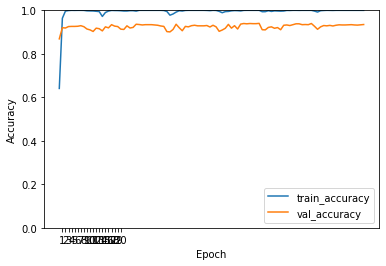

In [ ]:
### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )
## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_ResNet_with_oversample_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_ResNet_train_valid_with_oversample.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

# Improve fitted models with data augmentation on oversampled datasets

### load oversampling datasets (same way as before)


In [ ]:
### Create a test set (stratified sample 20% of 4750 total images)
os.mkdir('image_all/test/')
label_names = os.listdir('image_all/train/')
for label in label_names:
  os.mkdir('image_all/test/' + label)

random.seed(9345)
for label in label_names:
  imnames = os.listdir(os.path.join('image_all/train/', label))
  nb_sample = math.floor(len(imnames)*0.2)
  test_img_name = random.sample(imnames, nb_sample)
  print(len(test_img_name))
  for name in test_img_name:
    readpath = 'image_all/train/'+label+'/'+name
    img = Image.open(readpath)
    savepath = 'image_all/test/'+label+'/'+name
    img.save(savepath)
    os.remove(readpath)

    
### Oversample
labels = os.listdir('image_all/train/')
train_sizes = [len(os.listdir('image_all/train/' + x + '/')) for x in labels]
{x:y for x,y in zip(labels,train_sizes)}

random.seed(10)
for idx,label in enumerate(labels):
  if train_sizes[idx] < 200:
    ossize = 60
  elif train_sizes[idx] < 400:
    ossize = 40
  else:
    ossize = 1
  img_names = os.listdir('image_all/train/' + label)
  img_names_slect = random.sample(img_names, ossize)
  for name_i in img_names_slect:
    im=Image.open('image_all/train/' + label + '/' + name_i)
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    r.save('image_all/train/'+label+'/r_'+name_i)
    g=g.convert("RGB")
    g.save('image_all/train/'+label+'/g_'+name_i)
    b=b.convert("RGB")
    b.save('image_all/train/'+label+'/b_'+name_i)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)
    im_unsharp.save('image_all/train/'+label+'/unsharp_'+name_i)

103
44
78
52
44
46
130
122
95
57
99
77


NameError: ignored

### Begin data augmentation

In [ ]:
import random
from scipy import ndarray
import skimage as sk
from skimage import io
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

    
import random
import os

for label in labels:
  # our folder path containing some images
  folder_path = 'image_all/train/' + label
  # the number of file to generate
  num_files_desired = 300
  # loop on all files of the folder and build a list of files paths
  images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

  num_generated_files = 1
  while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = io.imread(image_path)
    # dictionary of the transformations functions we defined earlier
    available_transformations = {
        'rotate': random_rotation,
        'noise': random_noise,
        'horizontal_flip': horizontal_flip
    }

    # random num of transformations to apply (fixed at 1 for now)
    num_transformations_to_apply = 1

    num_transformations = 1
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
      # choose a random transformation to apply for a single image
      key = random.choice(list(available_transformations))
      transformed_image = available_transformations[key](image_to_transform)
      img = Image.fromarray(transformed_image, 'RGB')
      num_transformations += 1

      # define a name for our new file
      new_file_path = '%s/augimg_%s_%s.png' % (folder_path, label, num_generated_files)

      # write image to the disk
      img.save(new_file_path)
    num_generated_files += 1

### Image generator

In [ ]:
nb_epoch     = 100
batch_size   = 32
width        = 299
height       = 299


def define_generators():
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shift_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0.25, # change to use validation instead of training on entire training set
  )

  train_generator = train_datagen.flow_from_directory(
      directory='image_all/train/',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='training',
  )

  validation_generator = train_datagen.flow_from_directory(
      directory='image_all/train/',
      target_size=(width, height),
      batch_size=batch_size,
      color_mode='rgb',
      class_mode="categorical",
      subset='validation',
  )

  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      # rotation_range=360,
      # width_shift_range=0.3,
      # height_shift_range=0.3,
      # shear_range=0.3,
      # zoom_range=0.5,
      # vertical_flip=True,
      # horizontal_flip=True,
      validation_split=0,
  )

  test_generator = test_datagen.flow_from_directory(
      directory='image_all/test',
      target_size=(width, height),
      batch_size=1,
      color_mode='rgb',
      shuffle=False,
      class_mode='categorical')

  return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = define_generators()

Found 5555 images belonging to 12 classes.
Found 1848 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


### Fit CNN model

In [ ]:
model = tf.keras.models.Sequential()
# Input layer
# Can be omitted, you can specify the input_shape in other layers
model.add(tf.keras.layers.InputLayer(input_shape=(width,height,3,)))

# Here we add a 2D Convolution layer
# Check https://keras.io/api/layers/convolution_layers/convolution2d/ for more info
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

# Max Pool layer 
# It downsmaples the input representetion within the pool_size size
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
# The layer normalizes its output using the mean and standard deviation of the current batch of inputs.
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

# 2D Convolution layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides = (1,1), activation='relu'))

# Max Pool layer 
model.add(tf.keras.layers.MaxPool2D(pool_size = (2,2)))

# Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

# Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation='relu'))

# Dropout
# is used to nullify the outputs that are very close to zero and thus can cause overfitting.
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Normalization layer
model.add(tf.keras.layers.BatchNormalization())

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax')) # = 12 predicted classes


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
checkpoint = tf.keras.callbacks.ModelCheckpoint('drive/MyDrive/plant_seedlings_classification/plant_classifier_CNN_oversample_dataaug.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose = 1)

history = model.fit(train_generator,
          epochs=nb_epoch, # Increase number of epochs if you have sufficient hardware
          steps_per_epoch= train_generator.samples//batch_size,  # Number of train images // batch_size
          validation_data=validation_generator,
          validation_steps = validation_generator.samples//batch_size, # Number of val images // batch_size
          callbacks = [checkpoint],
          verbose = 1)

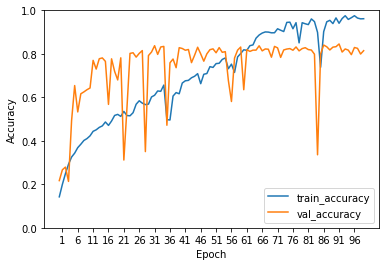

In [22]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/CNN_train_valid_with_oversample_dataaug.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 73, 73, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       7

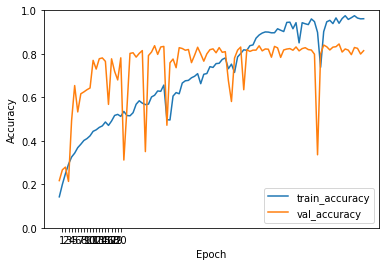

In [ ]:
### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )

## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_CNN_with_oversample_dataaug_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)
conf_mat

### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
import pandas as pd
save_name = 'modelresult_CNN_train_valid_with_oversample_dataaug.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### Fit InceptionResNetV2 model

In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='drive/MyDrive/plant_seedlings_classification/ResNet_with_oversample_dataaug.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return save_callback

def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
  
model = define_model(width, height)
model.summary()
save_callback = define_callbacks()

history = model.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[save_callback] #UNCOMMENT THIS LINE TO SAVE BEST VAL_ACC MODEL
)

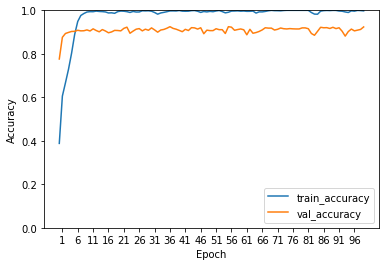

In [24]:
### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/ResNet_train_valid_with_oversample_dataaug.png')

219062272/219055592 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
flatten (Flatten)            (None, 98304)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12583040  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 66,921,324
Trainable params: 66,860,780
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/100
173/173 [======================

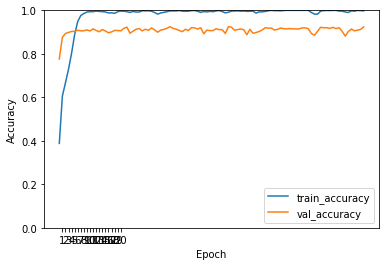

In [ ]:
### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )

## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_ResNet_with_oversample_dataaug_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_ResNet_train_valid_with_oversample_dataaug.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### Xception

83689472/83683744 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               26214528  
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 47,077,556
Trainable params: 47,023,028
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/100
173/173 [======================

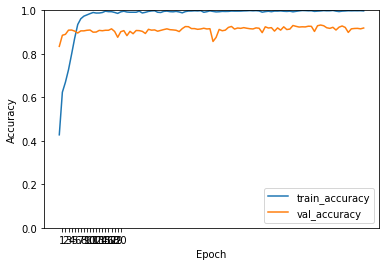

In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='drive/MyDrive/plant_seedlings_classification/Xception_with_oversample_dataaug.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return save_callback


def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.Xception(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
  
model = define_model(width, height)
model.summary()
save_callback = define_callbacks()

history = model.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[save_callback] #UNCOMMENT THIS LINE TO SAVE BEST VAL_ACC MODEL
)

### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,21)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/Xception_train_valid_with_oversample_dataaug.png')


history = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_ResNet_train_valid_with_oversample.csv')
plt.plot(history['accuracy'], label='train_accuracy')
plt.plot(history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,101,5)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/ResNet_train_valid_with_oversample.png')


### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )

## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_Xception_with_oversample_dataaug_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_Xception_train_valid_with_oversample_dataaug.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### ResNet50


In [ ]:
def define_callbacks():
    save_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='drive/MyDrive/plant_seedlings_classification/ResNet50_with_oversample_dataaug.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    return save_callback


def define_model(width, height):
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.application.ResNet50(include_top=False, weights='imagenet')(model_input)
    model_dense1 = tf.keras.layers.Flatten()(model_main)
    model_dense2 = tf.keras.layers.Dense(128, activation='relu')(model_dense1)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.00004, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
  
model = define_model(width, height)
model.summary()
save_callback = define_callbacks()

history = model.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[save_callback] #UNCOMMENT THIS LINE TO SAVE BEST VAL_ACC MODEL
)

### plot of train and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,21)))
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.savefig('drive/MyDrive/plant_seedlings_classification/ResNet50_train_valid_with_oversample_dataaug.png')

### Prediction on test set
predictions = model.predict(test_generator, steps=test_generator.samples)
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

class_list = []

for i in range(0, predictions.shape[0]):
  y_class = predictions[i, :].argmax(axis=-1)
  class_list += [species_list[y_class]]
true_class = [x.split('/')[0] for x in test_generator.filenames]
predict_class = class_list.copy()
conf_mat = sklearn.metrics.confusion_matrix(true_class, predict_class, labels=list(set(true_class)))
print(f'confusion matrix:\n{conf_mat}')
print('test_acc = ', sum(np.diag(conf_mat))/np.sum(conf_mat.flatten()) )

## save confusion matrix as 'modelresult_CNN_no_oversample_CFmat.csv'
save_name = 'modelresult_ResNet50_with_oversample_dataaug_CFmat.csv'
conf_mat = pd.DataFrame(conf_mat)
conf_mat.columns = list(set(true_class))
conf_mat.index = list(set(true_class))
conf_mat.to_csv(f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### save training History as  'modelresult_CNN_train_valid_no_oversample.csv'
save_name = 'modelresult_ResNet50_train_valid_with_oversample_dataaug.csv'
pd.DataFrame(history.history).to_csv( f"drive/MyDrive/plant_seedlings_classification/{save_name}", header = True, index=True)

### Confusion matrix heatmap

0.883843717001056

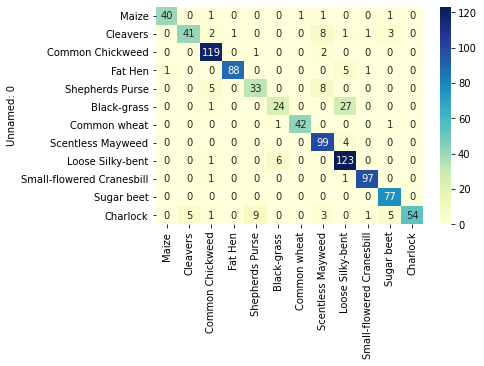

In [ ]:
import pandas as pd
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_CNN_no_oversample_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

0.9376979936642027

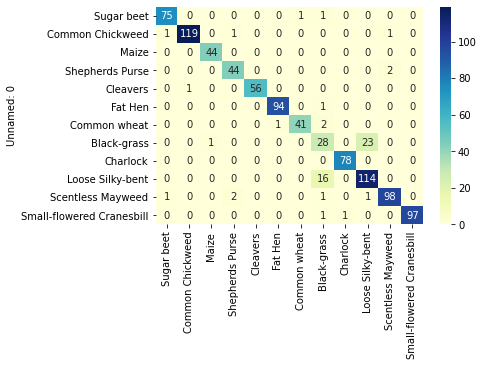

In [ ]:
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_ResNet_no_oversample_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

0.8521647307286166

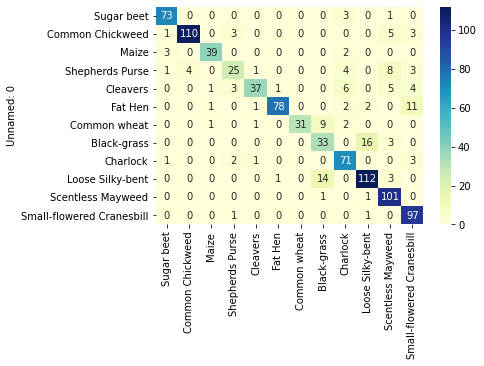

In [ ]:
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_CNN_with_oversample_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

0.9292502639915523

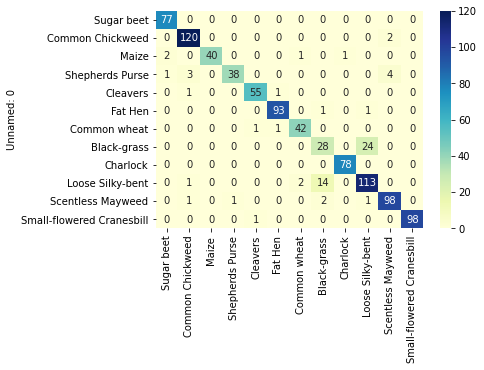

In [ ]:
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_ResNet_with_oversample_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

0.8458289334741288

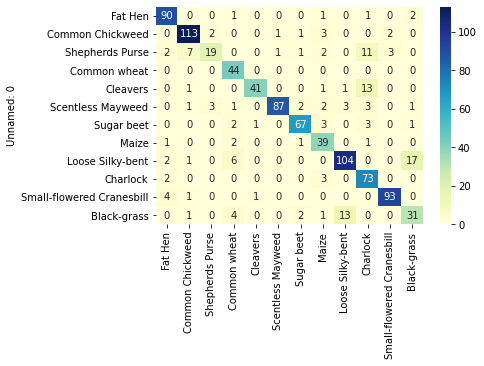

In [ ]:
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_CNN_with_oversample_dataaug_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()

0.9070749736008448

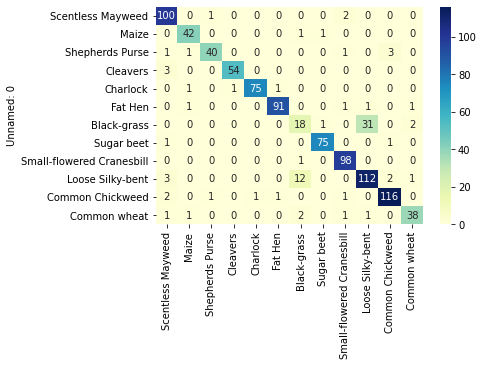

In [ ]:
a = pd.read_csv('drive/MyDrive/plant_seedlings_classification/modelresult_ResNet_with_oversample_dataaug_CFmat.csv')

a.index = a['Unnamed: 0']
a = a.drop(columns = ['Unnamed: 0'])
sns.heatmap(a, annot=True,fmt="d",cmap="YlGnBu")
sum(np.diag(a))/a.sum().sum()